In [9]:
# !pip install omicspylib

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from omicspylib import ProteinsDataset, PairwiseUniqueEntryComparison, PairwiseComparisonTTestFC, __version__
from omicspylib.plots import plot_density, plot_missing_values, plot_venn2, plot_volcano
print(f'omicspylib version: {__version__}')

omicspylib version: 0.0.3


In [11]:
data = pd.read_csv('data/protein_dataset.tsv', sep='\t')
data.head(3)

,protein_id,c1_rep1,c1_rep2,c1_rep3,c1_rep4,c1_rep5,c2_rep1,c2_rep2,c2_rep3,c2_rep4,c2_rep5,c3_rep1,c3_rep2,c3_rep3,c3_rep4,c3_rep5
0,p0,1748947.964,2655665.55,1812807.047,3179830.747,3002006.748,0.000,1357720.520,0.000,2087116.684,0.000,2558776.479,2655657.487,2115434.782,2889376.029,0.000
1,p1,1689613.957,0.00,1953790.640,2447525.246,2877005.859,1438315.297,1198347.576,1864606.985,0.000,1414141.418,0.000,3070691.996,3149289.453,0.000,2264704.900
2,p2,2053224.994,0.00,0.000,1729807.427,1307542.588,1062917.256,1466408.270,0.000,0.000,1461644.025,2538368.164,2136675.019,2565203.051,3772302.809,2793083.403


In [12]:
conditions = {
    'c1': [f'c1_rep{i+1}' for i in range(5)],
    'c2': [f'c2_rep{i+1}' for i in range(5)],
    'c3': [f'c3_rep{i+1}' for i in range(5)],
}
dataset = ProteinsDataset.from_df(data, id_col='protein_id', conditions=conditions)
dataset.describe()

{'n_conditions_total': 3,
 'n_records_total': 100,
 'n_experiments_total': 15,
 'statistics_per_condition': [{'name': 'c1',
   'n_experiments': 5,
   'n_records': 100,
   'experiment_names': ['c1_rep1', 'c1_rep2', 'c1_rep3', 'c1_rep4', 'c1_rep5'],
   'n_proteins_per_experiment': [74, 73, 67, 71, 76]},
  {'name': 'c2',
   'n_experiments': 5,
   'n_records': 100,
   'experiment_names': ['c2_rep1', 'c2_rep2', 'c2_rep3', 'c2_rep4', 'c2_rep5'],
   'n_proteins_per_experiment': [71, 70, 67, 68, 80]},
  {'name': 'c3',
   'n_experiments': 5,
   'n_records': 100,
   'experiment_names': ['c3_rep1', 'c3_rep2', 'c3_rep3', 'c3_rep4', 'c3_rep5'],
   'n_proteins_per_experiment': [80, 73, 78, 74, 80]}]}

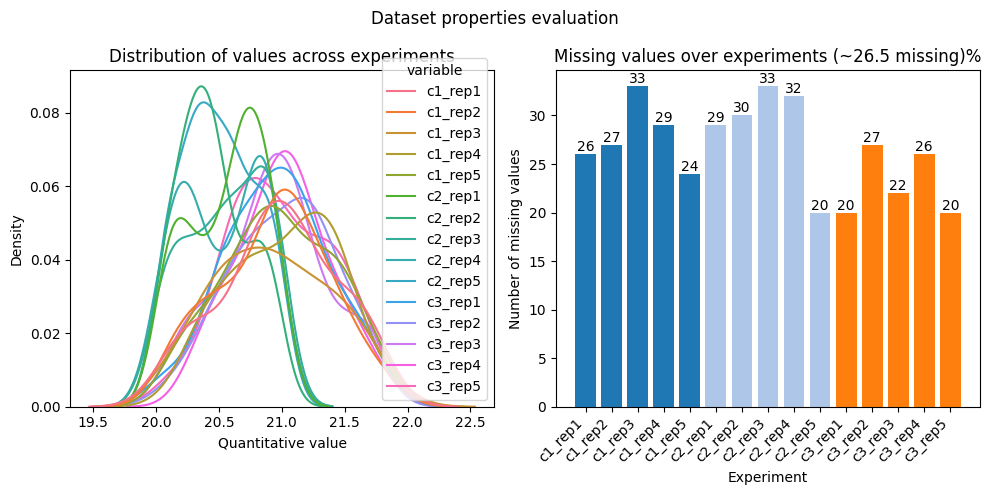

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_density(dataset=dataset.log2_transform(), ax=ax[0])
plot_missing_values(dataset=dataset, ax=ax[1])
plt.suptitle('Dataset properties evaluation')
plt.tight_layout()
plt.show()

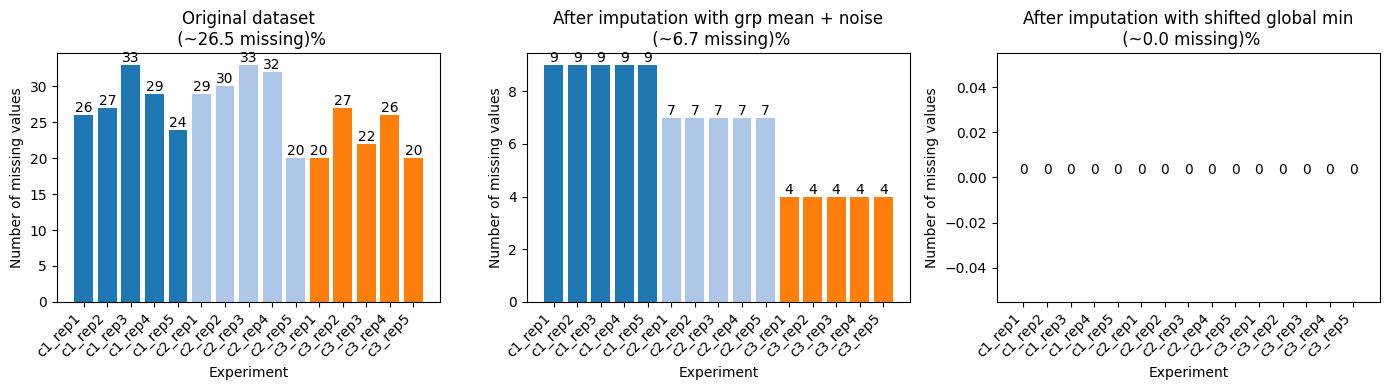

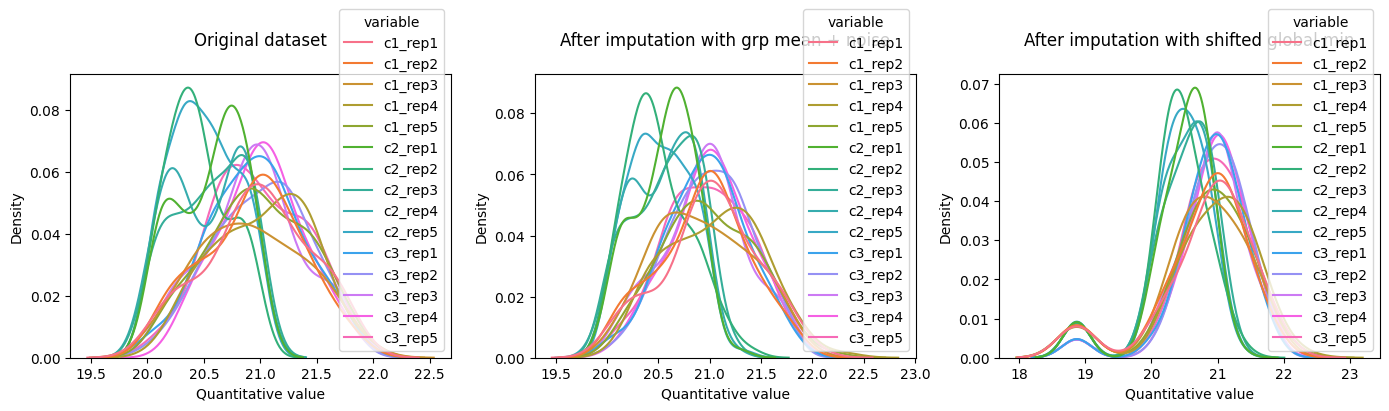

In [14]:
l2_dset = dataset.log2_transform()
grp_mean_l2_imputed_dset = l2_dset.impute(method='group row mean', random_noise=True)
l2_imputed_dset = grp_mean_l2_imputed_dset.impute(method='global min', shift=1.0)

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
plot_missing_values(dataset=l2_dset, ax=ax[0], title='Original dataset\n')
plot_missing_values(dataset=grp_mean_l2_imputed_dset, ax=ax[1], title='After imputation with grp mean + noise\n')
plot_missing_values(dataset=l2_imputed_dset, ax=ax[2], title='After imputation with shifted global min\n')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
plot_density(dataset=l2_dset, ax=ax[0], title='Original dataset\n')
plot_density(dataset=grp_mean_l2_imputed_dset, ax=ax[1], title='After imputation with grp mean + noise\n')
plot_density(dataset=l2_imputed_dset, ax=ax[2], title='After imputation with shifted global min\n')
plt.tight_layout()
plt.show()


In [18]:
imputed_dataset = grp_mean_l2_imputed_dset.log2_backtransform()
comparison = PairwiseComparisonTTestFC(imputed_dataset, condition_a='c1', condition_b='c2')
result = comparison.compare(pval_adj_method='fdr_bh')
result.head(3)

,c1_rep1,c1_rep2,c1_rep3,c1_rep4,c1_rep5,c2_rep1,c2_rep2,c2_rep3,c2_rep4,c2_rep5,p-value,t-statistic,adj-p-value,fold change,log2 fold change
protein_id,,,,,,,,,,,,,,,
p0,1748947.964,2.655666e+06,1812807.047,3179830.747,3.002007e+06,1.682660e+06,1.357721e+06,2.365561e+06,2.087117e+06,1.311743e+06,0.083635,1.975457,0.133196,1.408238,0.493891
p1,1689613.957,2.189425e+06,1953790.640,2447525.246,2.877006e+06,1.438315e+06,1.198348e+06,1.864607e+06,1.502804e+06,1.414141e+06,0.008430,3.471004,0.022656,1.504049,0.588852
p10,1757091.693,1.536626e+06,1149483.961,1600723.858,1.454509e+06,2.052588e+06,1.421743e+06,1.374370e+06,1.297363e+06,1.402528e+06,0.985877,-0.018263,0.985877,0.993355,-0.009618


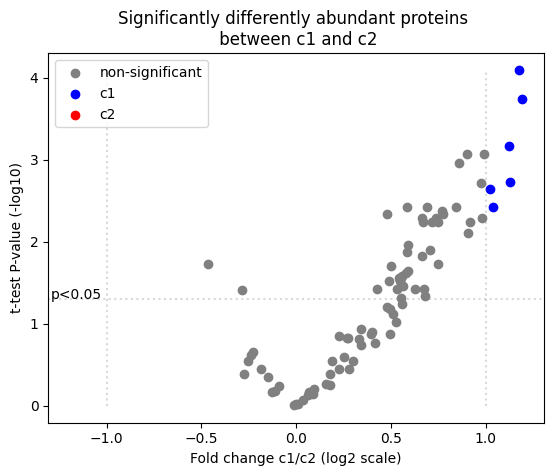

In [19]:
plot_volcano(result, pval_col='adj-p-value', fc_col='fold change', condition_a='c1', condition_b='c2')
plt.show()

In [17]:
output_df = imputed_dataset.to_table()
output_df.head(4)

,c1_rep1,c1_rep2,c1_rep3,c1_rep4,c1_rep5,c2_rep1,c2_rep2,c2_rep3,c2_rep4,c2_rep5,c3_rep1,c3_rep2,c3_rep3,c3_rep4,c3_rep5
protein_id,,,,,,,,,,,,,,,
p0,1748947.964,2.655666e+06,1812807.047,3.179831e+06,3.002007e+06,1.682660e+06,1.357721e+06,2.365561e+06,2.087117e+06,1.311743e+06,2.558776e+06,2.655657e+06,2115434.782,2.889376e+06,2.416455e+06
p1,1689613.957,2.189425e+06,1953790.640,2.447525e+06,2.877006e+06,1.438315e+06,1.198348e+06,1.864607e+06,1.502804e+06,1.414141e+06,2.319869e+06,3.070692e+06,3149289.453,4.138069e+06,2.264705e+06
p10,1757091.693,1.536626e+06,1149483.961,1.600724e+06,1.454509e+06,2.052588e+06,1.421743e+06,1.374370e+06,1.297363e+06,1.402528e+06,2.571566e+06,3.296322e+06,3648111.452,2.620469e+06,3.233381e+06
p11,2596847.916,2.592526e+06,2686205.008,3.245471e+06,2.684965e+06,1.461644e+06,1.528603e+06,1.837380e+06,1.226513e+06,1.329203e+06,1.624380e+06,2.106339e+06,1660887.127,1.920664e+06,1.852346e+06
